In [14]:
from pathlib import Path
from pydub import AudioSegment
from pydub.playback import play
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

In [2]:
path = 'audio_processing/demucs/htdemucs_preprocessed_100'
extensions = ["mp3"]

audio_filenames = []
for file in Path(path).iterdir():
    if file.suffix.lower().lstrip(".") in extensions:
        audio_filenames.append(str(file))

In [3]:
audio_filenames

['audio_processing/demucs/htdemucs_preprocessed_100/Tình Online Không Có Ngày Mai.mp3',
 'audio_processing/demucs/htdemucs_preprocessed_100/Áo Dài Việt Nam.mp3',
 'audio_processing/demucs/htdemucs_preprocessed_100/Canh Bạc Cuộc Đời.mp3',
 'audio_processing/demucs/htdemucs_preprocessed_100/Ước Muốn Của Em (Acoustic Version).mp3',
 'audio_processing/demucs/htdemucs_preprocessed_100/Bước Chân Con Trở Về.mp3',
 'audio_processing/demucs/htdemucs_preprocessed_100/Thương Em Miền Nước Lũ.mp3',
 'audio_processing/demucs/htdemucs_preprocessed_100/Mưa Nước Mắt.mp3',
 'audio_processing/demucs/htdemucs_preprocessed_100/Con Tim Em Đã Đổi Thay.mp3',
 'audio_processing/demucs/htdemucs_preprocessed_100/Búp bê bị hư.mp3',
 'audio_processing/demucs/htdemucs_preprocessed_100/Cuộc Tình Trong Mơ.mp3',
 'audio_processing/demucs/htdemucs_preprocessed_100/Ba Đứa Bạn Nghèo.mp3',
 'audio_processing/demucs/htdemucs_preprocessed_100/Hôm Nay Anh Đang Làm Gì？ (Beat).mp3',
 'audio_processing/demucs/htdemucs_preproces

In [74]:
sound = AudioSegment.from_file(audio_filenames[0], format="mp3")
sound1 = AudioSegment.from_file(audio_filenames[1], format="mp3")
# play(sound)

Mean dbFS:  -32.957633789017024


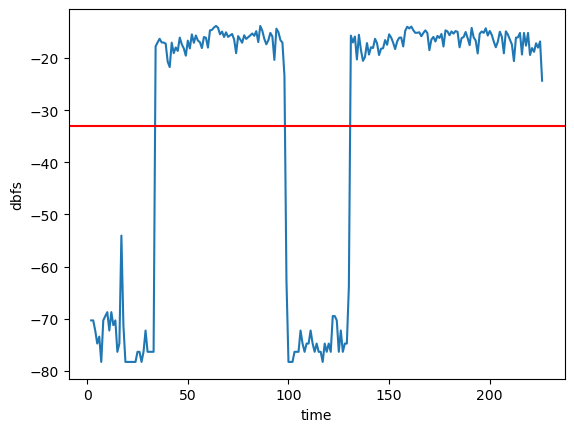

In [76]:
def plot_dbfs(audio_segment, time_window=1000) -> None:
    d = {'time': [], 'dbfs': []}
    for i, chunk in enumerate(audio_segment[::time_window]):
        d['time'].append(time_window*i/1000)
        d['dbfs'].append(chunk.dBFS)
    df = pd.DataFrame(data=d)
    sns.lineplot(data=df, x="time", y="dbfs")
    # plot average dbfs
    plot_df = df.replace(-np.inf, np.nan)
    plt.axhline(y = plot_df.loc[:, 'dbfs'].dropna().mean(), color = 'r', linestyle = '-') 
    print('Mean dbFS: ', plot_df.loc[:, 'dbfs'].dropna().mean())
    plt.show()

plot_dbfs(sound, time_window=1000)

In [126]:
def suppress_silence(audio:AudioSegment, time_window=1000, ignore_duration_multiple=2) -> AudioSegment:
    d = {'time': [], 'dbfs': []}
    for i, chunk in enumerate(audio[::time_window]):
        d['time'].append(time_window*i/1000)
        d['dbfs'].append(chunk.dBFS)
    df = pd.DataFrame(data=d)

    plot_df = df.copy(deep=True).replace(-np.inf, np.nan)
    mean_dbfs = plot_df.loc[:, 'dbfs'].dropna().mean()

    ignore_duration = int((time_window/1000)*ignore_duration_multiple)
    df['dbfs_prev'] = df['dbfs'].shift(periods=ignore_duration)
    df['dbfs_after'] = df['dbfs'].shift(periods=-ignore_duration)
    df['silence'] = df.apply(lambda x: True if ((x['dbfs'] < mean_dbfs) & ((x['dbfs_prev'] < mean_dbfs) | (x['dbfs_prev']== np.nan)) & (x['dbfs_after'] < mean_dbfs) | (x['dbfs'] == -np.inf)) else False, axis=1)
    # silence_df = df.loc[(df['dbfs'] < mean_dbfs) & (df['dbfs_prev'] < mean_dbfs) & (df['dbfs_after'] < mean_dbfs)]
    # print(df.iloc[136:140,:])
    prev_time = None
    prev_action = None
    curr_time = None
    curr_action = None
    cache = {}
    for idx, row in enumerate(df.itertuples()):
        # sample of row: Index=0, time=0.0, dbfs=-84.28839878591472, dbfs_prev=nan, dbfs_after=-80.76657360480111, silence=False
        if prev_time == None:
            # print('test: ', row)
            prev_time = row[1]
            prev_action = row[5]

        curr_time = row[1]
        curr_action = row[5]
        if prev_action != curr_action:
            # print(row)
            cache[idx] = {'action':prev_action, 'start':int(prev_time*1000), 'stop': int(curr_time*1000)}
            prev_time = curr_time
            prev_action = curr_action
        
        if idx == len(df)-1:
            cache[idx] = {'action':prev_action, 'start':int(prev_time*1000), 'stop': int(curr_time*1000)}
    print(cache)
    output = AudioSegment.empty()
    for _, v in cache.items():
        if v['action']: # True -> apply silence
            duration = v['stop'] - v['start']
            output += AudioSegment.silent(duration=duration)
        else: # False -> append original audio
            output += audio[v['start']:v['stop']]
    return output
    pass

suppress_audio = suppress_silence(sound, time_window=1000, ignore_duration_multiple=2)

{32: {'action': True, 'start': 0, 'stop': 32000}, 101: {'action': False, 'start': 32000, 'stop': 101000}, 129: {'action': True, 'start': 101000, 'stop': 129000}, 226: {'action': False, 'start': 129000, 'stop': 226000}}


In [122]:
len(suppress_audio)

226000

In [123]:
len(sound)

226247

Mean dbFS:  -18.579979224440457


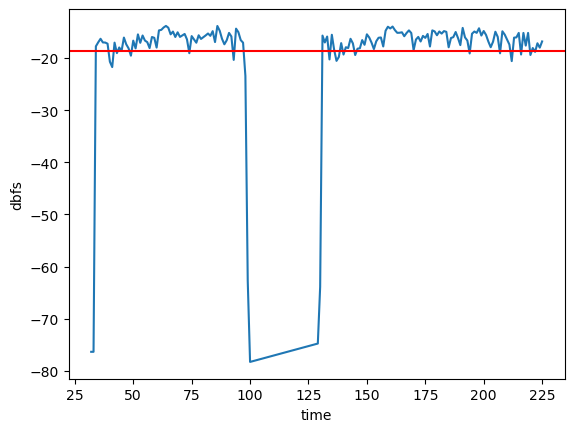

In [128]:
plot_dbfs(suppress_audio, time_window=1000)

### Play the audio

In [ ]:
play(suppress_audio)

### Export Audio

In [127]:
# simple export
file_handle = suppress_audio.export("output.mp3", format="mp3")